## Time Series Forecasting with Exogenous variables

In [105]:
import os
os.environ["PYCARET_CRITICAL_LOGGING"] = "critical"

In [106]:
def installed_data():
  from pycaret import show_versions
  show_versions()

try:
  installed_data()
except ModuleNotFoundError:
  !pip install pycaret
  installed_data()


System:
    python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-5.15.109+-x86_64-with-glibc2.35

PyCaret required dependencies:
                 pip: 23.1.2
          setuptools: 67.7.2
             pycaret: 3.0.4
             IPython: 7.34.0
          ipywidgets: 7.7.1
                tqdm: 4.66.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.1
              joblib: 1.3.2
             sklearn: 1.2.2
                pyod: 1.1.0
            imblearn: 0.10.1
   category_encoders: 2.6.2
            lightgbm: 4.0.0
               numba: 0.56.4
            requests: 2.31.0
          matplotlib: 3.7.1
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.15.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.0
              sktime: 0.22.0
               tbats: 1.1.3
            pmda

In [107]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_sales.csv to synthetic_sales (1).csv


In [121]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment


In [122]:
global_figure={
    'renderer':'png',
    'width': '600',
    'height':'600'
}

In [134]:
sales_data = get_data('synthetic_sales')
sales_data['datetime_column'] = pd.to_datetime(sales_data["Date"] + " " + sales_data["Time"])
sales_data.drop(columns=["Date",'Time'], inplace= True)
target ="Sales"

,Date,Time,Sales,Promotion,Weekday,Weather
0,1/1/2022,15:29,299.951051,0,Saturday,Sunny
1,1/2/2022,12:28,302.322607,1,Sunday,Snowy
2,1/3/2022,19:45,307.592219,0,Monday,Rainy
3,1/4/2022,16:52,308.700960,0,Tuesday,Sunny
4,1/5/2022,13:05,294.588928,0,Wednesday,Sunny


In [135]:
sales_data[sales_data[target]== '307.592219'].head()

,Sales,Promotion,Weekday,Weather,datetime_column


## Exploratory Data Analysis

In [136]:
import pandas as pd

# Assuming your datetime column is named 'datetime_column'
sales_data['datetime_column'] = pd.to_datetime(sales_data['datetime_column'])
sales_data.set_index('datetime_column', inplace=True)
sales_data = sales_data.resample('W').sum()
from pycaret.time_series import TSForecastingExperiment



In [137]:
eda = TSForecastingExperiment()

In [139]:
eda.setup(
    data = sales_data,
    target= "Sales",
    fh=10,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    fig_kwargs = global_figure,
    session_id = 123,
)

,Description,Value
0,session_id,123
1,Target,Sales
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(53, 2)"
5,Transformed data shape,"(53, 2)"
6,Transformed train set shape,"(43, 2)"
7,Transformed test set shape,"(10, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


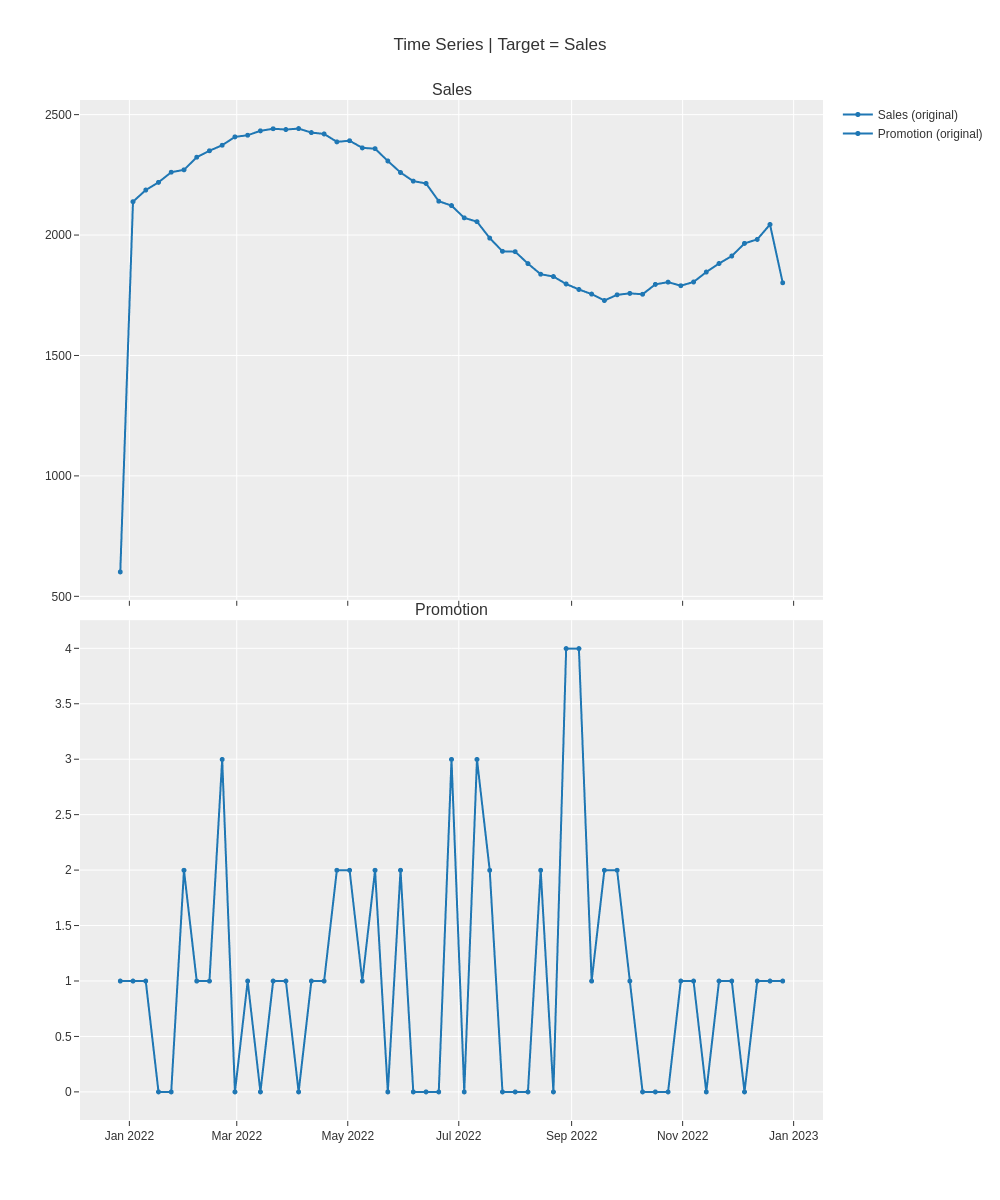

In [144]:
eda.plot_model(fig_kwargs={ 'renderer':'png', 'width': 1000,'height':1200})

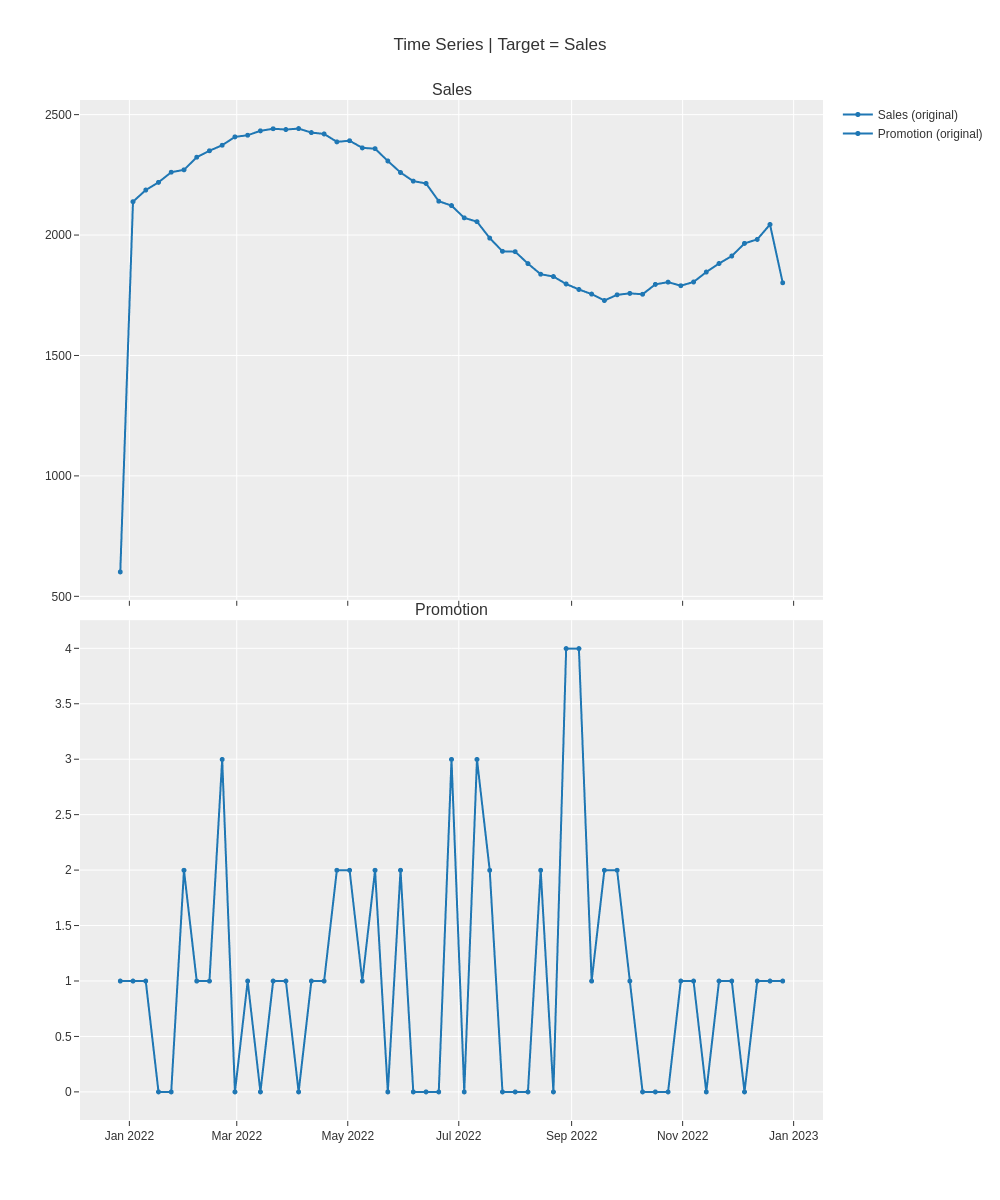

In [148]:
eda.plot_model(
    plot='ts',
    fig_kwargs={
        'height': 1200,
        'width':1000,
        "re-sample-kwargs": {
            "default_n_show_samples":1500,
            "show_dash": {"mode" : "inline", "port":8080},

            },
    },

)

In [152]:
exclude=[302.322607]

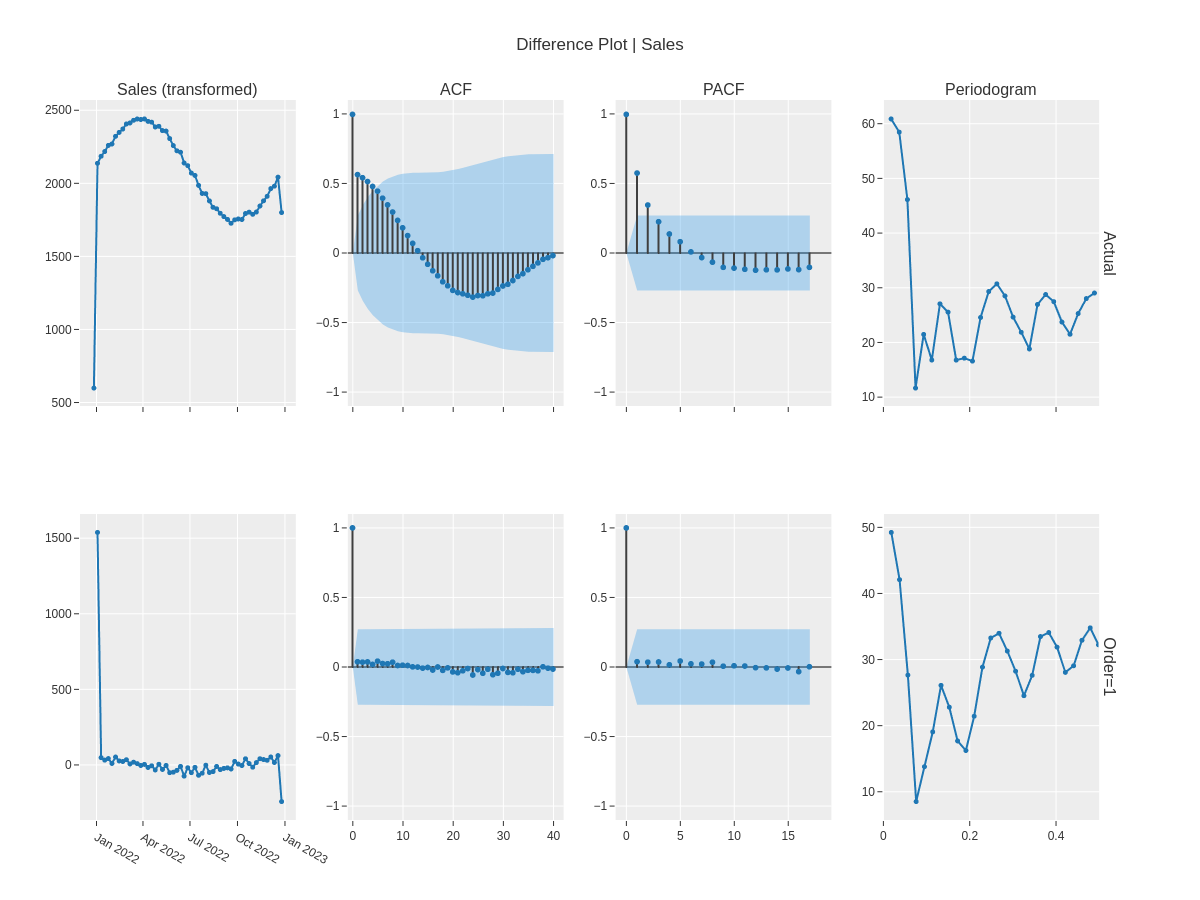

In [154]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height":900,
        'width':1200,
        "resampler_kwargs":{"default_show_samples":1500}

    },
    data_kwargs={"acf":True, "pacf":True, "periodogram": True},

)

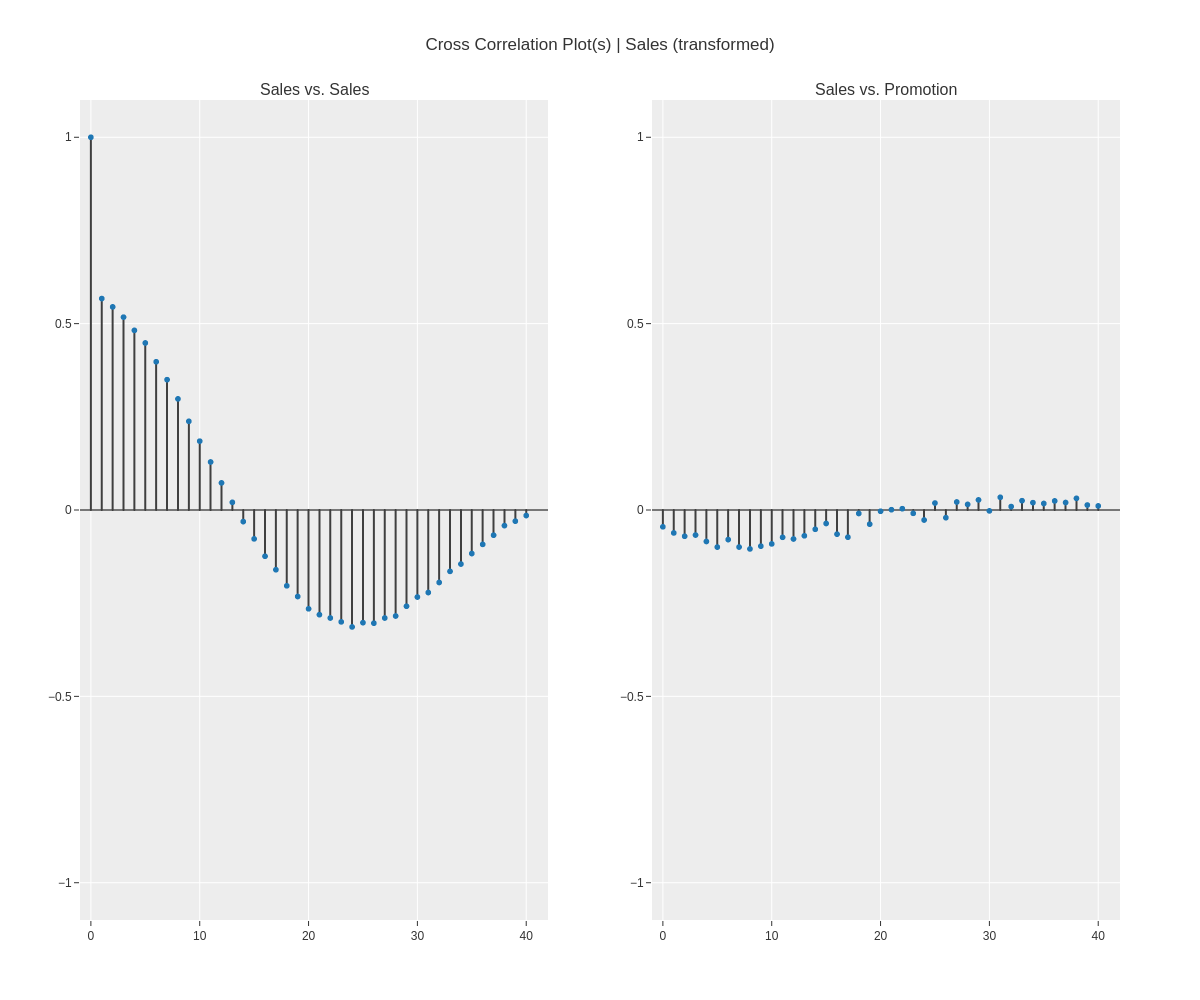

In [155]:
eda.plot_model(plot="ccf", fig_kwargs={'height':1000, 'width':1200})

## Baseline_Model

In [181]:
data_univar = sales_data.copy()
data_univar = data_univar[target]
exp_univar = TSForecastingExperiment()
exp_univar.setup(
    data=data_univar,
    fh=10,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    fig_kwargs= global_figure,
    session_id=123
)

,Description,Value
0,session_id,123
1,Target,Sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(53, 1)"
5,Transformed data shape,"(53, 1)"
6,Transformed train set shape,"(43, 1)"
7,Transformed test set shape,"(10, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [190]:
model = exp_univar.create_model("arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-03-21/2022-03-27,1.2252,0.4395,187.9821,195.6212,0.0784,0.0819,-11.1085
1,2022-05-30/2022-06-05,0.7954,0.2934,73.7661,96.6001,0.0376,0.0364,0.2893
2,2022-08-08/2022-08-14,2.0202,0.5845,152.6998,160.2101,0.0863,0.0824,-21.6271
Mean,NaT,1.3469,0.4391,138.1494,150.8105,0.0675,0.0669,-10.8154
SD,NaT,0.5074,0.1188,47.7501,40.9679,0.0214,0.0216,8.9497


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Improved Model

In [199]:
exp_exogenous = TSForecastingExperiment()
exp_exogenous.setup(
    data=sales_data,
    target=target,
    fh=10,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    fig_kwargs=global_figure,
    session_id=42
)

,Description,Value
0,session_id,42
1,Target,Sales
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(53, 2)"
5,Transformed data shape,"(53, 2)"
6,Transformed train set shape,"(43, 2)"
7,Transformed test set shape,"(10, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [201]:
model_exogenous = exp_exogenous.create_model("arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-03-21/2022-03-27,1.5192,0.5345,233.0999,237.9068,0.0976,0.1029,-16.9091
1,2022-05-30/2022-06-05,1.6165,0.5570,149.9155,183.3654,0.0759,0.0718,-1.5606
2,2022-08-08/2022-08-14,5.0065,1.4031,378.4293,384.6117,0.2134,0.1922,-129.4048
Mean,NaT,2.7141,0.8315,253.8149,268.6280,0.1290,0.1223,-49.2915
SD,NaT,1.6215,0.4043,94.4333,84.9818,0.0603,0.0510,56.9941


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluate Model

In [203]:
final_model_exogenous = exp_exogenous.finalize_model(model_exogenous)

In [204]:
def safe_predict(exp_sales, model):
    try:
        exp_sales.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp_sales.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_exogenous, final_model_exogenous)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
1 exogenous variables (X) needed in order to make future predictions:
['Promotion']
